In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        # input is 28x28
        # padding=2 for same padding
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        # feature map size is 14*14 by pooling
        # padding=2 for same padding
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        # feature map size is 7*7 by pooling
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7)   # reshape Variable
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
model = MnistModel()
model

MnistModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [3]:
batch_size = 50
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

Using downloaded and verified file: data\MNIST\raw\train-images-idx3-ubyte.gz
Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw
Using downloaded and verified file: data\MNIST\raw\train-labels-idx1-ubyte.gz
Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw
Processing...


..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!



In [4]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1000)

In [5]:
for p in model.parameters():
    print(p.size())

torch.Size([32, 1, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([1024, 3136])
torch.Size([1024])
torch.Size([10, 1024])
torch.Size([10])


In [6]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [15]:
train_loss = []
train_accu = []
i = 0
for epoch in range(15):
    for data, target in train_loader:
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()    # calc gradients
        train_loss.append(loss.item())
        optimizer.step()   # update gradients
        prediction = output.data.max(1)[1]   # first column has actual prob.
        accuracy = prediction.eq(target.data).sum()/batch_size*100
        train_accu.append(accuracy)
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.item(), accuracy))
        i += 1

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Step: 0	Loss: 0.017	Accuracy: 0.000


KeyboardInterrupt: 

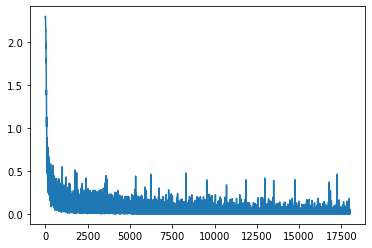

In [12]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(len(train_loss)), train_loss)

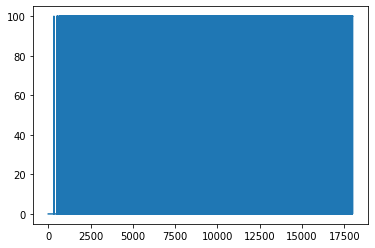

In [13]:
plt.plot(np.arange(len(train_accu)), train_accu)

In [16]:
model.eval()
correct = 0
for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('\nTest set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Accuracy: 99.31%
